In [2]:

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score,
                             accuracy_score, log_loss, precision_recall_fscore_support,
                             roc_curve, precision_recall_curve, auc)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA


try:
    import xgboost as xgb
    HAS_XGB = True
except Exception:
    HAS_XGB = False

# imblearn optional
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    HAS_IMBLEARN = True
except Exception:
    HAS_IMBLEARN = False


%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (8,5)


Initial shape: (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62,110,80,1,1,0,0,1,0
1,1,20228,1,156,85,140,90,3,1,0,0,1,1
2,2,18857,1,165,64,130,70,3,1,0,0,0,1
3,3,17623,2,169,82,150,100,1,1,0,0,1,1
4,4,17474,1,156,56,100,60,1,1,0,0,0,0



Cardio class balance (proportion):
cardio
0    0.5003
1    0.4997
Name: proportion, dtype: float64


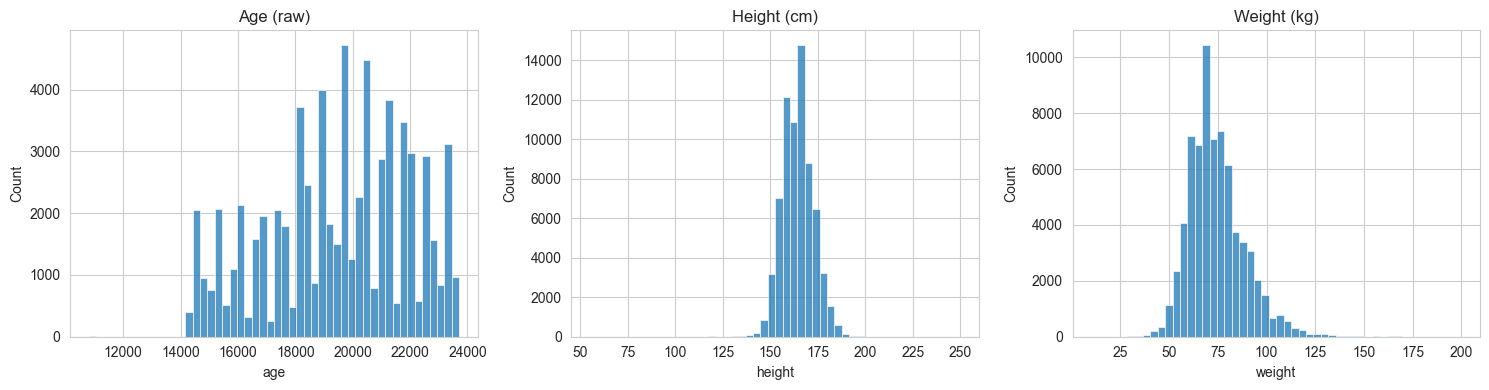

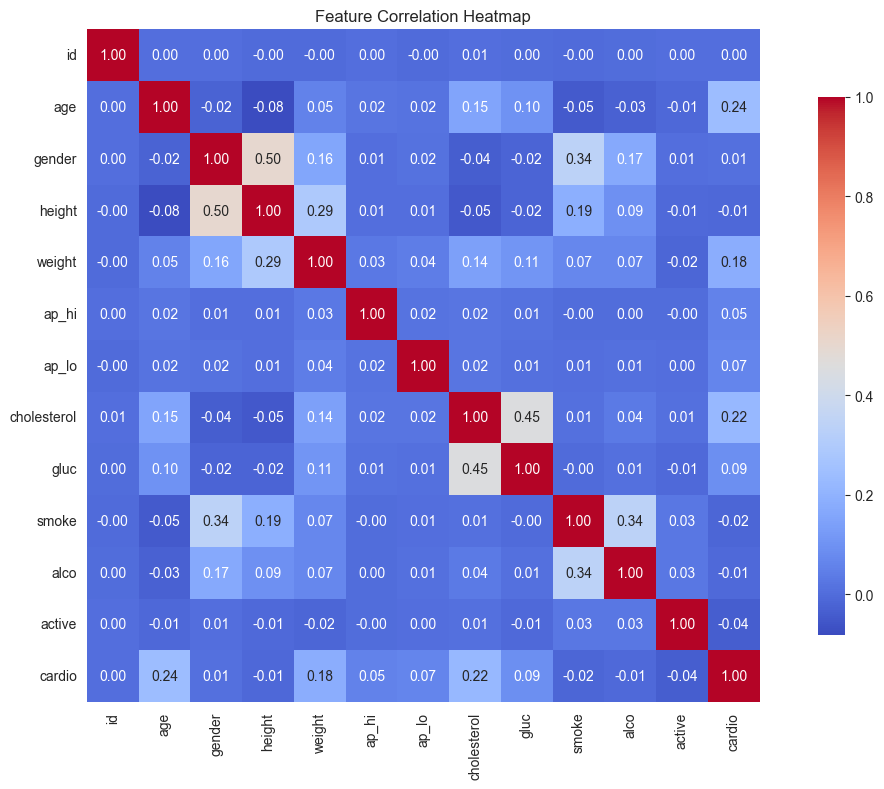

In [3]:
# quick EDA
df = pd.read_csv("cardio_train.csv")
print("Initial shape:", df.shape)
display(df.head())

# class balance
print("\nCardio class balance (proportion):")
print(df['cardio'].value_counts(normalize=True))

# basic distributions
fig, axes = plt.subplots(1,3, figsize=(15,4))
sns.histplot(df['age'], bins=50, ax=axes[0]).set_title("Age (raw)")
sns.histplot(df['height'], bins=50, ax=axes[1]).set_title("Height (cm)")
sns.histplot(df['weight'], bins=50, ax=axes[2]).set_title("Weight (kg)")
plt.tight_layout()
plt.show()

# correlation heatmap
plt.figure(figsize=(12,8))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.8})
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


In [3]:
#preprocessing & feature engineering
def preprocess_df(df):
    df = df.copy()
    # age -> years if days
    if df['age'].median() > 120:
        df['age_years'] = (df['age'] / 365).round(1)
    else:
        df['age_years'] = df['age']
    # BMI
    df['height_m'] = df['height'] / 100.0
    df['bmi'] = df['weight'] / (df['height_m'] ** 2 + 1e-9)
    df.drop(columns=['height_m'], inplace=True)
    # pulse pressure and ratio
    df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']
    df['sbp_dbp_ratio'] = df['ap_hi'] / (df['ap_lo'] + 1e-9)
    # clean heuristics
    df = df[(df['ap_hi'] > 30) & (df['ap_hi'] < 300)]
    df = df[(df['ap_lo'] > 10) & (df['ap_lo'] < 200)]
    df = df[(df['height'] > 100) & (df['height'] < 220)]
    df = df[(df['weight'] > 20) & (df['weight'] < 300)]
    # cast categories
    cat_cols = ['gender','cholesterol','gluc','smoke','alco','active']
    for c in cat_cols:
        if c in df.columns:
            df[c] = df[c].astype('category')
    return df

df = preprocess_df(df)
print("After cleaning:", df.shape)
display(df[['age_years','bmi','pulse_pressure']].describe())


After cleaning: (68765, 17)


,age_years,bmi,pulse_pressure
count,68765.000000,68765.000000,68765.000000
mean,53.327613,27.471027,45.250651
std,6.761240,5.344154,12.215520
min,29.600000,7.022248,-90.000000
25%,48.400000,23.875115,40.000000
50%,54.000000,26.346494,40.000000
75%,58.400000,30.119376,50.000000
max,65.000000,152.551775,160.000000


In [4]:
# build pipeline and CV evaluate models
target = 'cardio'
X = df.drop(columns=[target, 'id', 'age'])
y = df[target]

numeric_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_features = X.select_dtypes(include=['category']).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", cat_features)

num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_transformer = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer([('num', num_transformer, numeric_features), ('cat', cat_transformer, cat_features)], remainder='drop')

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print("Train/test shapes:", X_train.shape, X_test.shape)

# candidate models
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "NaiveBayes": GaussianNB(),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(64,32), max_iter=500, random_state=42)
}
if HAS_XGB:
    models["XGBoost"] = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

def evaluate_model(name, model):
    pipe = Pipeline([('preproc', preprocessor), ('clf', model)])
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipe, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)
    print(f"{name} CV ROC AUC: mean={scores.mean():.4f} std={scores.std():.4f}")
    return pipe, scores.mean()

results = {}
for name, model in models.items():
    pipe, mean_auc = evaluate_model(name, model)
    results[name] = {'pipeline': pipe, 'cv_auc': mean_auc}

best_name = max(results.items(), key=lambda kv: kv[1]['cv_auc'])[0]
best_pipe = results[best_name]['pipeline']
print("Best by CV AUC:", best_name)


Numeric features: ['height', 'weight', 'ap_hi', 'ap_lo', 'age_years', 'bmi', 'pulse_pressure', 'sbp_dbp_ratio']
Categorical features: ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
Train/test shapes: (55012, 14) (13753, 14)
LogisticRegression CV ROC AUC: mean=0.7914 std=0.0041
KNN CV ROC AUC: mean=0.7595 std=0.0032
NaiveBayes CV ROC AUC: mean=0.7559 std=0.0048
RandomForest CV ROC AUC: mean=0.7708 std=0.0042
MLP CV ROC AUC: mean=0.7840 std=0.0057
XGBoost CV ROC AUC: mean=0.7919 std=0.0049
Best by CV AUC: XGBoost


In [10]:
best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)[:, 1]

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_proba))
print("Log Loss:", log_loss(y_test, y_proba))
print("Classification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# ---- Save Test Data for Streamlit UI ----
pd.DataFrame(X_test).to_csv("X_test.csv", index=False)
pd.DataFrame({"y_test": y_test}).to_csv("y_test.csv", index=False)
pd.DataFrame({"y_pred": y_pred, "y_proba": y_proba}).to_csv("y_pred.csv", index=False)

print("Saved test data for dashboard: X_test.csv, y_test.csv, y_pred.csv")


Test Accuracy: 0.7331491310986694
Test ROC AUC: 0.8003933870686037
Log Loss: 0.5424973408677306
Classification report:
               precision    recall  f1-score   support

           0       0.72      0.78      0.75      6946
           1       0.76      0.68      0.72      6807

    accuracy                           0.73     13753
   macro avg       0.74      0.73      0.73     13753
weighted avg       0.74      0.73      0.73     13753

Confusion matrix:
 [[5443 1503]
 [2167 4640]]
Saved test data for dashboard: X_test.csv, y_test.csv, y_pred.csv


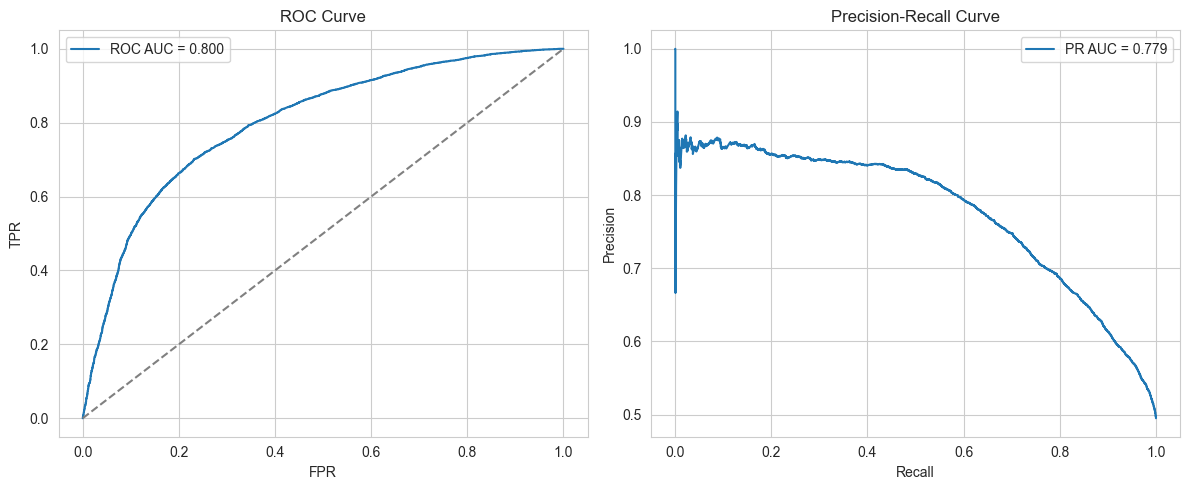

In [11]:
# ROC and Precision-Recall curves
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

prec, rec, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(rec, prec)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend()

plt.subplot(1,2,2)
plt.plot(rec, prec, label=f"PR AUC = {pr_auc:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve"); plt.legend()

plt.tight_layout()
plt.show()


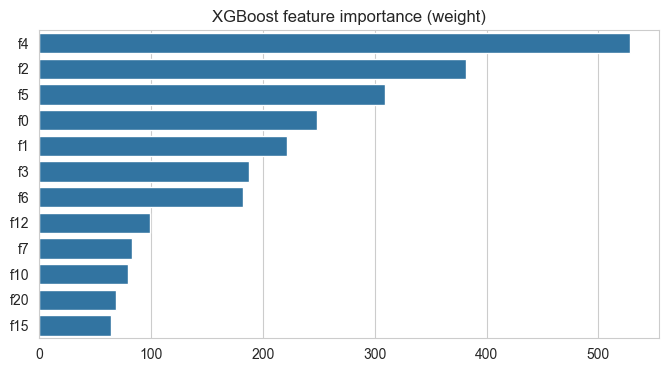

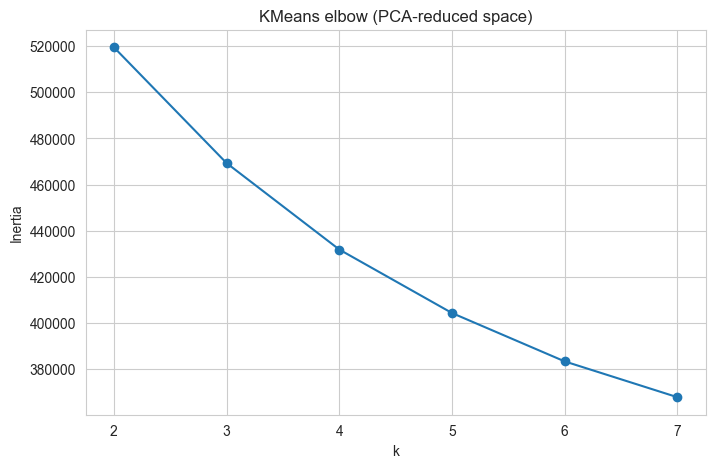

In [12]:
# feature importance + PCA+KMeans elbow
# Feature importance
try:
    clf = best_pipe.named_steps['clf']
    pre = best_pipe.named_steps['preproc']
    # get feature names after preprocessor (numeric + onehot)
    num_cols = numeric_features
    # get onehot feature names
    ohe_cols = []
    if hasattr(pre, 'transformers_'):
        for name, trans, cols in pre.transformers_:
            if name == 'cat':
                ohe = trans.named_steps['onehot']
                cat_cols_local = cols
                ohe_cols = list(ohe.get_feature_names_out(cat_cols_local))
    feat_names = num_cols + ohe_cols
    # importance for tree models
    if HAS_XGB and hasattr(clf, 'get_booster'):
        fi = clf.get_booster().get_score(importance_type='weight')
        # map to full list
        imp = {k:fi.get(k,0) for k in fi}
        items = sorted(imp.items(), key=lambda x: x[1], reverse=True)
        # plot top 12
        names = [k for k,_ in items][:12]
        vals = [v for _,v in items][:12]
        plt.figure(figsize=(8,4)); sns.barplot(x=vals, y=names); plt.title("XGBoost feature importance (weight)"); plt.show()
    elif hasattr(clf, 'feature_importances_'):
        importances = clf.feature_importances_
        # if shape mismatch, sum per original feature (approx)
        if len(importances) == len(feat_names):
            idx = np.argsort(importances)[::-1][:12]
            plt.figure(figsize=(8,4)); sns.barplot(x=importances[idx], y=np.array(feat_names)[idx]); plt.title("Feature importances"); plt.show()
        else:
            # fallback: plot top importances directly
            idx = np.argsort(importances)[::-1][:12]
            plt.figure(figsize=(8,4)); sns.barplot(x=importances[idx], y=[f"f{i}" for i in idx]); plt.title("Feature importances (indices)"); plt.show()
    else:
        print("Feature importance not available for this model type.")
except Exception as e:
    print("Feature importance skipped:", e)

# PCA + KMeans elbow (exploratory)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
X_pre = preprocessor.fit_transform(X)  # note: exploratory; do not use for modeling leakage
pca = PCA(n_components=10, random_state=42)
Xp = pca.fit_transform(X_pre)
inertia = []
K = range(2,8)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(Xp)
    inertia.append(km.inertia_)

plt.figure(); plt.plot(K, inertia, marker='o'); plt.title("KMeans elbow (PCA-reduced space)"); plt.xlabel("k"); plt.ylabel("Inertia"); plt.show()


Starting GridSearch...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
GridSearch best params: {'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 400}
GridSearch best CV AUC: 0.8012873142340968
After tuning - Test Accuracy: 0.7331491310986694
After tuning - Test ROC AUC: 0.8003933870686037


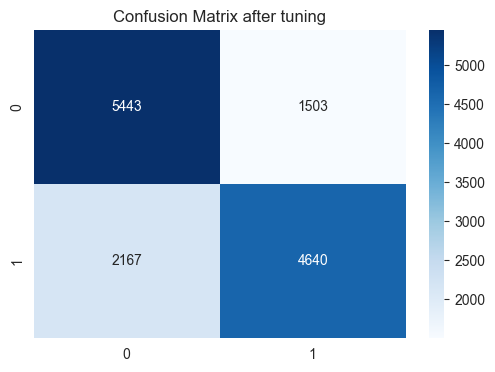

In [8]:
#hyperparameter tuning for best candidate (example for XGBoost or RandomForest)
if best_name == "RandomForest":
    param_grid = {
        'clf__n_estimators': [200,400],
        'clf__max_depth': [8,12,16,None],
        'clf__min_samples_split': [2,4,6]
    }
elif best_name == "XGBoost" and HAS_XGB:
    param_grid = {
        'clf__n_estimators': [200,400],
        'clf__max_depth': [3,6,8],
        'clf__learning_rate': [0.01,0.05,0.1]
    }
else:
    param_grid = None

if param_grid is not None:
    gs = GridSearchCV(best_pipe, param_grid, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
    print("Starting GridSearch...")
    gs.fit(X_train, y_train)
    print("GridSearch best params:", gs.best_params_)
    print("GridSearch best CV AUC:", gs.best_score_)
    best_pipe = gs.best_estimator_
    # Re-evaluate
    y_pred = best_pipe.predict(X_test)
    y_proba = best_pipe.predict_proba(X_test)[:,1] if hasattr(best_pipe,'predict_proba') else best_pipe.decision_function(X_test)
    print("After tuning - Test Accuracy:", accuracy_score(y_test, y_pred))
    print("After tuning - Test ROC AUC:", roc_auc_score(y_test, y_proba))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues'); plt.title("Confusion Matrix after tuning"); plt.show()
else:
    print("No param grid for the chosen best_name:", best_name)


In [13]:
# Cell 9: save model and summary
import joblib
joblib.dump(best_pipe, "best_cardio_model_final.joblib")
print("Saved model to best_cardio_model_final.joblib")

print("\nFINAL SUMMARY:")
y_pred = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)[:,1] if hasattr(best_pipe,'predict_proba') else None
print("Accuracy:", accuracy_score(y_test, y_pred))
if y_proba is not None:
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))


Saved model to best_cardio_model_final.joblib

FINAL SUMMARY:
Accuracy: 0.7331491310986694
ROC AUC: 0.8003933870686037

Classification report:
               precision    recall  f1-score   support

           0     0.7152    0.7836    0.7479      6946
           1     0.7553    0.6817    0.7166      6807

    accuracy                         0.7331     13753
   macro avg     0.7353    0.7326    0.7322     13753
weighted avg     0.7351    0.7331    0.7324     13753

